Image batch shape: torch.Size([32, 3, 128, 128])
Parameters batch shape: torch.Size([32, 24])
Min: -27.6353, Max: 41.2406, Std: 7.3882, Median: 0.0215


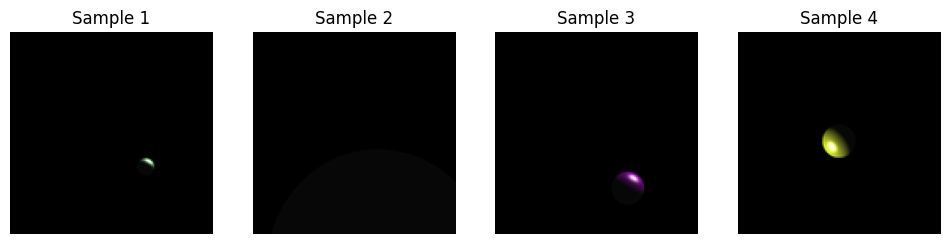

In [10]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math

class FrameDataset(Dataset):
    def __init__(self, csv_path, image_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.transform = transform
        
        self.camera_pos = [5.0, 5.0, 15.0]
        
        self.max_r = math.sqrt(25**2 + 25**2 + 35**2)  # Max radial distance
        self.r_range = [0, self.max_r]
        self.theta_range = [0, math.pi]
        self.phi_range = [-math.pi, math.pi]
        self.shininess_range = [3, 20]
        self.diffuse_range = [0, 1]
        
        self.image_files = [f"image_{str(i).zfill(4)}.png" for i in self.data['frame']]
        
        self.params_tensor = self.preprocess_data()
        
    def __len__(self):
        return len(self.data)
    
    def normalize(self, value, range_min, range_max):
        """Normalize value to [-1, 1]."""
        normalized = (value - range_min) / (range_max - range_min)
        return 2 * normalized - 1
    
    def get_orthonormal_basis(self, z_prime):
        """Compute orthonormal basis with z_prime as the z'-axis."""
        ref = [0, 0, 1]
        if abs(z_prime[2]) > 0.99:
            ref = [0, 1, 0]
        
        x_prime = [
            z_prime[1] * ref[2] - z_prime[2] * ref[1],
            z_prime[2] * ref[0] - z_prime[0] * ref[2],
            z_prime[0] * ref[1] - z_prime[1] * ref[0]
        ]
        x_norm = math.sqrt(sum(x * x for x in x_prime))
        x_prime = [x / x_norm for x in x_prime]
        
        y_prime = [
            z_prime[1] * x_prime[2] - z_prime[2] * x_prime[1],
            z_prime[2] * x_prime[0] - z_prime[0] * x_prime[2],
            z_prime[0] * x_prime[1] - z_prime[1] * x_prime[0]
        ]
        y_norm = math.sqrt(sum(y * y for y in y_prime))
        y_prime = [y / y_norm for y in y_prime]
        
        return x_prime, y_prime, z_prime
    
    def cartesian_to_spherical_lookat(self, x, y, z, lookat_vec):
        """Convert relative Cartesian coordinates to spherical coordinates aligned with lookat vector."""
        x_prime, y_prime, z_prime = self.get_orthonormal_basis(lookat_vec)
        
        x_new = x * x_prime[0] + y * x_prime[1] + z * x_prime[2]
        y_new = x * y_prime[0] + y * y_prime[1] + z * y_prime[2]
        z_new = x * z_prime[0] + y * z_prime[1] + z * z_prime[2]
        
        # Convert to spherical coordinates
        r = math.sqrt(x_new**2 + y_new**2 + z_new**2)
        theta = math.acos(z_new / r) if r > 0 else 0
        phi = math.atan2(y_new, x_new)
        
        return r, theta, phi
    
    def preprocess_data(self):
        """Preprocess all data to compute spherical coordinates and additional relative features."""
        params_list = []

        for idx in range(len(self.data)):
            row = self.data.iloc[idx]

            lookat_x_rel = row['lookat_target_x'] - self.camera_pos[0]
            lookat_y_rel = row['lookat_target_y'] - self.camera_pos[1]
            lookat_z_rel = row['lookat_target_z'] - self.camera_pos[2]
            lookat_norm = math.sqrt(lookat_x_rel**2 + lookat_y_rel**2 + lookat_z_rel**2)
            lookat_vec = (
                lookat_x_rel / lookat_norm if lookat_norm > 0 else 0,
                lookat_y_rel / lookat_norm if lookat_norm > 0 else 0,
                lookat_z_rel / lookat_norm if lookat_norm > 0 else 0
            )

            model_x_rel = row['model_translation_x'] - self.camera_pos[0]
            model_y_rel = row['model_translation_y'] - self.camera_pos[1]
            model_z_rel = row['model_translation_z'] - self.camera_pos[2]
            model_r, model_theta, model_phi = self.cartesian_to_spherical_lookat(
                model_x_rel, model_y_rel, model_z_rel, lookat_vec
            )

            light_x_rel = row['light_position_x'] - self.camera_pos[0]
            light_y_rel = row['light_position_y'] - self.camera_pos[1]
            light_z_rel = row['light_position_z'] - self.camera_pos[2]
            light_r, light_theta, light_phi = self.cartesian_to_spherical_lookat(
                light_x_rel, light_y_rel, light_z_rel, lookat_vec
            )

            light_to_model_vec = [
                light_x_rel - model_x_rel,
                light_y_rel - model_y_rel,
                light_z_rel - model_z_rel
            ]
            ltm_norm = math.sqrt(sum(x**2 for x in light_to_model_vec))
            light_to_model_unit = [x / ltm_norm if ltm_norm > 0 else 0 for x in light_to_model_vec]

            cos_view_light = sum(l * v for l, v in zip(light_to_model_unit, lookat_vec))
            ltm_normalized = self.normalize(ltm_norm, 0, self.max_r)

            x_prime, y_prime, z_prime = self.get_orthonormal_basis(lookat_vec)
            def rotate_to_view(x, y, z):
                return [
                    x * x_prime[0] + y * x_prime[1] + z * x_prime[2],
                    x * y_prime[0] + y * y_prime[1] + z * y_prime[2],
                    x * z_prime[0] + y * z_prime[1] + z * z_prime[2],
                ]
            model_view_xyz = rotate_to_view(model_x_rel, model_y_rel, model_z_rel)
            light_view_xyz = rotate_to_view(light_x_rel, light_y_rel, light_z_rel)

            params = [
                self.normalize(model_r, *self.r_range),
                self.normalize(model_theta, *self.theta_range),
                self.normalize(model_phi, *self.phi_range),
                self.normalize(light_r, *self.r_range),
                self.normalize(light_theta, *self.theta_range),
                self.normalize(light_phi, *self.phi_range),
                lookat_vec[0],
                lookat_vec[1],
                lookat_vec[2],
                self.normalize(row['material_diffuse_r'], *self.diffuse_range),
                self.normalize(row['material_diffuse_g'], *self.diffuse_range),
                self.normalize(row['material_diffuse_b'], *self.diffuse_range),
                self.normalize(row['material_shininess'], *self.shininess_range),
                ltm_normalized,
                cos_view_light,
                *light_to_model_unit,
                *model_view_xyz,
                *light_view_xyz
            ]

            params_list.append(params)

        return torch.tensor(params_list, dtype=torch.float32)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        params_tensor = self.params_tensor[idx]
        
        return image, params_tensor
    
def denormalize(img):
    """Denormalize images from [-1, 1] to [0, 1] for visualization."""
    return (img * 0.5) + 0.5

def get_data_loaders(csv_path, image_dir, batch_size=32, train_split=0.8):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    dataset = FrameDataset(csv_path, image_dir, transform=transform)
    
    train_size = int(train_split * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

csv_path = "../output/frame_parameters.csv"
image_dir = "../output"
batch_size = 32

train_loader, val_loader = get_data_loaders(csv_path, image_dir, batch_size)

for images, params in train_loader:
    print(f"Image batch shape: {images.shape}")
    print(f"Parameters batch shape: {params.shape}")
    
    min_val = torch.min(params)
    max_val = torch.max(params)
    std_val = torch.std(params)
    median_val = torch.median(params)
    
    print(f"Min: {min_val.item():.4f}, Max: {max_val.item():.4f}, "
          f"Std: {std_val.item():.4f}, Median: {median_val.item():.4f}")
    
    num_samples = min(4, images.size(0))
    plt.figure(figsize=(12, 3))
    for i in range(num_samples):
        img = denormalize(images[i])
        if img.ndim == 3 and img.shape[0] in [1, 3]:
            img = img.permute(1, 2, 0)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img.squeeze().numpy(), cmap='gray' if img.shape[-1] == 1 else None)
        plt.axis('off')
        plt.title(f"Sample {i+1}")
    plt.show()
    break

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

class SingleConv(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim=32):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.t_emb_proj = nn.Linear(t_emb_dim, out_channels)
    
    def forward(self, x, t_emb):
        t_emb = self.t_emb_proj(t_emb)[:, :, None, None]
        x = self.conv(x) + t_emb
        return x

class CrossAttention(nn.Module):
    def __init__(self, in_channels, cond_dim, t_emb_dim=32):
        super().__init__()
        self.query = nn.Linear(in_channels, in_channels // 2)
        self.key = nn.Linear(cond_dim, in_channels // 2)
        self.value = nn.Linear(cond_dim, in_channels)
        self.scale = (in_channels // 2) ** -0.5
        self.t_emb_proj = nn.Linear(t_emb_dim, in_channels // 2)
    
    def forward(self, x, cond, t_emb):
        batch, channels, h, w = x.shape
        x_flat = x.view(batch, channels, -1).permute(0, 2, 1)
        q = self.query(x_flat)
        k = self.key(cond).unsqueeze(1)
        v = self.value(cond).unsqueeze(1)
        t_emb = self.t_emb_proj(t_emb).unsqueeze(1)
        q = q + t_emb
        attn = F.softmax(q @ k.transpose(-2, -1) * self.scale, dim=-1)
        out = (attn @ v).permute(0, 2, 1).view(batch, channels, h, w)
        return x + out

class VariationalAutoEncoder(nn.Module):
    def __init__(self, latent_channels=128):
        super().__init__()
        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.enc_conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.enc_conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        self.enc_mu = nn.Conv2d(128, latent_channels, 3, padding=1)
        self.enc_logvar = nn.Conv2d(128, latent_channels, 3, padding=1)
        
        # Decoder
        self.dec_up1 = nn.ConvTranspose2d(latent_channels, 128, 2, stride=2)
        self.dec_conv1 = nn.Conv2d(128, 64, 3, padding=1)
        self.dec_up2 = nn.ConvTranspose2d(64, 64, 2, stride=2)
        self.dec_conv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.dec_out = nn.Conv2d(32, 3, 1)
    
    def encode(self, x):
        x = self.relu(self.enc_conv1(x))
        x = self.pool(x)  # (32, 64, 64)
        x = self.relu(self.enc_conv2(x))
        x = self.pool(x)  # (64, 32, 32)
        x = self.relu(self.enc_conv3(x))  # (128, 32, 32)
        mu = self.enc_mu(x)  # (latent_channels, 32, 32)
        logvar = self.enc_logvar(x)  # (latent_channels, 32, 32)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        z = self.relu(self.dec_up1(z))  # (128, 64, 64)
        z = self.relu(self.dec_conv1(z))  # (64, 64, 64)
        z = self.relu(self.dec_up2(z))  # (64, 128, 128)
        z = self.relu(self.dec_conv2(z))  # (32, 128, 128)
        z = self.dec_out(z)  # (3, 128, 128)
        return torch.tanh(z)  # Output in [-1, 1]
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

class LatentUNet(nn.Module):
    def __init__(self, in_channels=128, out_channels=128, cond_dim=128, t_emb_dim=32):
        super().__init__()
        self.inc = SingleConv(in_channels, 256, t_emb_dim)
        
        self.down1 = nn.MaxPool2d(2)
        self.conv_down1 = SingleConv(256, 512, t_emb_dim)
        
        self.bottleneck = SingleConv(512, 1024, t_emb_dim)
        self.attn = CrossAttention(1024, cond_dim, t_emb_dim)
        
        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv_up1 = SingleConv(512 + 256, 512, t_emb_dim)
        
        self.outc = nn.Conv2d(512, out_channels, 1)
    
    def forward(self, z, t, cond):
        t_emb = self.get_timestep_embedding(t, t_emb_dim=32).to(z.device)
        z1 = self.inc(z, t_emb)  # (256, 32, 32)
        z2 = self.down1(z1)  # (256, 16, 16)
        z2 = self.conv_down1(z2, t_emb)  # (512, 16, 16)
        
        z = self.bottleneck(z2, t_emb)  # (1024, 16, 16)
        z = self.attn(z, cond, t_emb)
        
        z = self.up1(z)  # (512, 32, 32)
        z = self.conv_up1(torch.cat([z, z1], dim=1), t_emb)  # (512, 32, 32)
        return self.outc(z)  # (128, 32, 32)
    
    def get_timestep_embedding(self, t, t_emb_dim):
        t = t.view(-1, 1)
        half_dim = t_emb_dim // 2
        emb = torch.exp(-torch.arange(half_dim, device=t.device).float() / half_dim * math.log(10000))
        emb = t * emb
        return torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)

class CondEncoder(nn.Module):
    def __init__(self, input_dim=24, output_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, output_dim // 2),
            nn.ReLU(),
            nn.Linear(output_dim // 2, output_dim),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.net(x)

class ConditionalDiffusion(nn.Module):
    def __init__(self, steps=512):
        super().__init__()
        self.vae = VariationalAutoEncoder(latent_channels=128)
        self.cond_encoder = CondEncoder(input_dim=24, output_dim=128)
        self.latent_unet = LatentUNet(in_channels=128, out_channels=128, cond_dim=128, t_emb_dim=32)
        self.steps = steps
        self.betas = self.get_beta_schedule(steps)
        self.alphas = 1.0 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0).to(device='cuda' if torch.cuda.is_available() else 'cpu')
    
    def get_beta_schedule(self, T):
        beta_start = 0.0001
        beta_end = 0.02
        return torch.linspace(beta_start, beta_end, T)
    
    def forward_diffusion(self, z0, t):
        noise = torch.randn_like(z0)
        sqrt_alpha_bar = torch.sqrt(self.alpha_bars[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bars[t])[:, None, None, None]
        zt = sqrt_alpha_bar * z0 + sqrt_one_minus_alpha_bar * noise
        return zt, noise
    
    def forward(self, z, t, cond):
        conv_emb = self.cond_encoder(cond)
        return self.latent_unet(z, t, conv_emb)
    
    def sample(self, params, latent_size=(128, 32, 32)):
        self.eval()
        device = next(self.parameters()).device
        z = torch.randn(1, *latent_size).to(device)
        params = params.to(device)
        cond_emb = self.cond_encoder(params)
        
        for t in reversed(range(self.steps)):
            t_tensor = torch.full((1,), t, dtype=torch.long, device=device)
            noise_pred = self.latent_unet(z, t_tensor, cond_emb)
            alpha = self.alphas[t]
            alpha_bar = self.alpha_bars[t]
            z = (z - (1 - alpha) / torch.sqrt(1 - alpha_bar) * noise_pred) / torch.sqrt(alpha)
            if t > 0:
                z += torch.sqrt(self.betas[t]) * torch.randn_like(z)
        
        x = self.vae.decode(z)
        return x.clamp(-1, 1)
    
def visualize_vae_comparison(vae, images, epoch, device, num_samples=4, output_dir='vae_visualizations'):
    vae.eval()
    os.makedirs(output_dir, exist_ok=True)
    
    num_samples = min(num_samples, len(images))
    if num_samples == 0:
        print("No samples to visualize.")
        return
    
    images = images[:num_samples].to(device)
    
    with torch.no_grad():
        recon_images, mu, logvar = vae(images)
    
    mse = F.mse_loss(images, recon_images, reduction='none').mean(dim=(1, 2, 3))
    
    real_images = (images + 1) / 2
    recon_images = (recon_images + 1) / 2
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, 4 * num_samples))
    if num_samples == 1:
        axes = [axes]
    else:
        axes = axes.reshape(num_samples, 2)
    
    for i in range(num_samples):
        real_img = real_images[i].permute(1, 2, 0).cpu().numpy()
        axes[i][0].imshow(real_img)
        axes[i][0].set_title(f"Real Image {i+1}")
        axes[i][0].axis('off')
        
        recon_img = recon_images[i].permute(1, 2, 0).cpu().numpy()
        axes[i][1].imshow(recon_img)
        axes[i][1].set_title(f"Reconstructed Image {i+1}\nMSE: {mse[i].item():.4f}")
        axes[i][1].axis('off')
    
    plt.suptitle(f"Real vs Reconstructed Comparison (Epoch {epoch})")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    output_path = os.path.join(output_dir, f"vae_comparison_epoch_{epoch}.png")
    plt.savefig(output_path)
    plt.close()
    print(f"Saved VAE visualization to {output_path}")

def pretrain_vae(vae, train_loader, val_loader, epochs=10, device='cuda' if torch.cuda.is_available() else 'cpu', checkpoint_dir='vae_checkpoints'):
    vae.to(device)
    optimizer = torch.optim.AdamW(vae.parameters(), lr=1e-3)
    
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    start_epoch = 0
    best_val_loss = float('inf')
    last_checkpoint_path = os.path.join(checkpoint_dir, 'vae_last_model.pth')
    
    if os.path.exists(last_checkpoint_path):
        checkpoint = torch.load(last_checkpoint_path, map_location=device)
        vae.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = checkpoint['best_val_loss']
        print(f"Loaded VAE checkpoint from {last_checkpoint_path}, resuming from epoch {start_epoch}")
    
    val_iter = iter(val_loader)
    vis_images, _ = next(val_iter)
    vis_images = vis_images.to(device)
    
    for epoch in range(start_epoch, epochs):
        vae.train()
        train_loss = 0
        for images, _ in tqdm(train_loader, desc=f"VAE Epoch {epoch+1}/{epochs}"):
            images = images.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = vae(images)
            recon_loss = F.mse_loss(recon, images, reduction='sum') / images.size(0)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / images.size(0)
            loss = recon_loss + 0.1 * kl_loss
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        val_loss = 0
        vae.eval()
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)
                recon, mu, logvar = vae(images)
                recon_loss = F.mse_loss(recon, images, reduction='sum') / images.size(0)
                kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / images.size(0)
                loss = recon_loss + 0.1 * kl_loss
                val_loss += loss.item()
        
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(val_loader)
        print(f"VAE Epoch {epoch+1}, Train Loss: {train_loss_avg:.4f}, Val Loss: {val_loss_avg:.4f}")
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': vae.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
        }, last_checkpoint_path)
        print(f"Saved VAE last model to {last_checkpoint_path}")
        
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            best_checkpoint_path = os.path.join(checkpoint_dir, 'vae_best_model.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': vae.state_dict(),
                'optimization_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
            }, best_checkpoint_path)
            print(f"Saved VAE best model to {best_checkpoint_path} with Val Loss: {best_val_loss:.4f}")
        
        if (epoch + 1) % 10 == 0:
            visualize_vae_comparison(vae, vis_images, epoch + 1, device, num_samples=4)

def visualize_comparison(model, images, params, epoch, device, num_samples=4, output_dir='diff_visualizations'):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    
    num_samples = min(num_samples, len(images), len(params))
    if num_samples == 0:
        print("No samples to visualize.")
        return
    
    images = images[:num_samples].to(device)
    param_samples = params[:num_samples].to(device)
    
    generated_images = []
    with torch.no_grad():
        for i in range(num_samples):
            gen_img = model.sample(param_samples[i:i+1], latent_size=(128, 32, 32))
            generated_images.append(gen_img.squeeze(0))
    
    generated_images = torch.stack(generated_images)
    
    mse = F.mse_loss(images, generated_images, reduction='none').mean(dim=(1, 2, 3))
    
    real_images = (images + 1) / 2
    generated_images = (generated_images + 1) / 2
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, 4 * num_samples))
    if num_samples == 1:
        axes = [axes]
    else:
        axes = axes.reshape(num_samples, 2)
    
    for i in range(num_samples):
        real_img = real_images[i].permute(1, 2, 0).cpu().numpy()
        axes[i][0].imshow(real_img)
        axes[i][0].set_title(f"Real Image {i+1}")
        axes[i][0].axis('off')
        
        gen_img = generated_images[i].permute(1, 2, 0).cpu().numpy()
        axes[i][1].imshow(gen_img)
        axes[i][1].set_title(f"Generated Image {i+1}\nMSE: {mse[i].item():.4f}")
        axes[i][1].axis('off')
    
    plt.suptitle(f"Real vs Generated Comparison (Epoch {epoch})")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    output_path = os.path.join(output_dir, f"comparison_epoch_{epoch}.png")
    plt.savefig(output_path)
    plt.close()
    print(f"Saved visualization to {output_path}")

def train_diffusion(model, train_loader, val_loader, epochs=10, device='cuda' if torch.cuda.is_available() else 'cpu', checkpoint_dir='diff_checkpoints'):
    model.to(device)
    model.vae.eval()
    optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad and not any(p is param for param in model.vae.parameters())], lr=1e-5)
    
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    start_epoch = 0
    best_val_loss = float('inf')
    last_checkpoint_path = os.path.join(checkpoint_dir, 'last_model.pth')
    
    if os.path.exists(last_checkpoint_path):
        checkpoint = torch.load(last_checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = checkpoint['best_val_loss']
        print(f"Loaded checkpoint from {last_checkpoint_path}, resuming from epoch {start_epoch}")
    
    val_iter = iter(val_loader)
    vis_images, vis_params = next(val_iter)
    vis_images, vis_params = vis_images.to(device), vis_params.to(device)
    
    for epoch in range(start_epoch, epochs):
        model.train()
        model.vae.eval()
        train_loss = 0
        for images, params in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, params = images.to(device), params.to(device)
            with torch.no_grad():
                mu, _ = model.vae.encode(images)
            t = torch.randint(0, len(model.betas), (images.size(0),), device=device)
            zt, noise = model.forward_diffusion(mu, t)
            noise_pred = model(zt, t, params)
            loss = F.mse_loss(noise_pred, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for images, params in val_loader:
                images, params = images.to(device), params.to(device)
                mu, _ = model.vae.encode(images)
                t = torch.randint(0, len(model.betas), (images.size(0),), device=device)
                zt, noise = model.forward_diffusion(mu, t)
                noise_pred = model(zt, t, params)
                loss = F.mse_loss(noise_pred, noise)
                val_loss += loss.item()
        
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}, Train Loss: {train_loss_avg:.4f}, Val Loss: {val_loss_avg:.4f}")
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
        }, last_checkpoint_path)
        print(f"Saved last model to {last_checkpoint_path}")
        
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            best_checkpoint_path = os.path.join(checkpoint_dir, 'best_model.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
            }, best_checkpoint_path)
            print(f"Saved best model to {best_checkpoint_path} with Val Loss: {best_val_loss:.4f}")
        
        if (epoch + 1) % 10 == 0:
            visualize_comparison(model, vis_images, vis_params, epoch + 1, device, num_samples=4)

In [12]:
vae = VariationalAutoEncoder(latent_channels=128)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pretrain_vae(vae, train_loader, val_loader, epochs=300, device=device, checkpoint_dir='vae_checkpoints')

Loaded VAE checkpoint from vae_checkpoints/vae_last_model.pth, resuming from epoch 300


In [13]:
model = ConditionalDiffusion(steps=512)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.vae.load_state_dict(torch.load('vae_checkpoints/vae_best_model.pth')['model_state_dict'])
train_diffusion(model, train_loader, val_loader, epochs=400, device=device)

Loaded checkpoint from diff_checkpoints/last_model.pth, resuming from epoch 135


Epoch 136/400: 100%|██████████| 63/63 [00:08<00:00,  7.72it/s]


Epoch 136, Train Loss: 0.0573, Val Loss: 0.0533
Saved last model to diff_checkpoints/last_model.pth


Epoch 137/400: 100%|██████████| 63/63 [00:08<00:00,  7.75it/s]


Epoch 137, Train Loss: 0.0523, Val Loss: 0.0704
Saved last model to diff_checkpoints/last_model.pth


Epoch 138/400: 100%|██████████| 63/63 [00:08<00:00,  7.70it/s]


Epoch 138, Train Loss: 0.0554, Val Loss: 0.0619
Saved last model to diff_checkpoints/last_model.pth


Epoch 139/400: 100%|██████████| 63/63 [00:08<00:00,  7.75it/s]


Epoch 139, Train Loss: 0.0538, Val Loss: 0.0553
Saved last model to diff_checkpoints/last_model.pth


Epoch 140/400: 100%|██████████| 63/63 [00:08<00:00,  7.58it/s]


Epoch 140, Train Loss: 0.0536, Val Loss: 0.0552
Saved last model to diff_checkpoints/last_model.pth
Saved visualization to diff_visualizations/comparison_epoch_140.png


Epoch 141/400: 100%|██████████| 63/63 [00:08<00:00,  7.69it/s]


Epoch 141, Train Loss: 0.0541, Val Loss: 0.0595
Saved last model to diff_checkpoints/last_model.pth


Epoch 142/400: 100%|██████████| 63/63 [00:08<00:00,  7.84it/s]


Epoch 142, Train Loss: 0.0579, Val Loss: 0.0443
Saved last model to diff_checkpoints/last_model.pth
Saved best model to diff_checkpoints/best_model.pth with Val Loss: 0.0443


Epoch 143/400: 100%|██████████| 63/63 [00:08<00:00,  7.70it/s]


Epoch 143, Train Loss: 0.0561, Val Loss: 0.0578
Saved last model to diff_checkpoints/last_model.pth


Epoch 144/400: 100%|██████████| 63/63 [00:08<00:00,  7.65it/s]


Epoch 144, Train Loss: 0.0610, Val Loss: 0.0601
Saved last model to diff_checkpoints/last_model.pth


Epoch 145/400: 100%|██████████| 63/63 [00:08<00:00,  7.67it/s]


Epoch 145, Train Loss: 0.0577, Val Loss: 0.0590
Saved last model to diff_checkpoints/last_model.pth


Epoch 146/400: 100%|██████████| 63/63 [00:08<00:00,  7.38it/s]


Epoch 146, Train Loss: 0.0553, Val Loss: 0.0542
Saved last model to diff_checkpoints/last_model.pth


Epoch 147/400: 100%|██████████| 63/63 [00:08<00:00,  7.80it/s]


Epoch 147, Train Loss: 0.0511, Val Loss: 0.0636
Saved last model to diff_checkpoints/last_model.pth


Epoch 148/400: 100%|██████████| 63/63 [00:08<00:00,  7.73it/s]


Epoch 148, Train Loss: 0.0513, Val Loss: 0.0487
Saved last model to diff_checkpoints/last_model.pth


Epoch 149/400: 100%|██████████| 63/63 [00:08<00:00,  7.53it/s]


Epoch 149, Train Loss: 0.0486, Val Loss: 0.0518
Saved last model to diff_checkpoints/last_model.pth


Epoch 150/400: 100%|██████████| 63/63 [00:08<00:00,  7.78it/s]


Epoch 150, Train Loss: 0.0519, Val Loss: 0.0521
Saved last model to diff_checkpoints/last_model.pth
Saved visualization to diff_visualizations/comparison_epoch_150.png


Epoch 151/400: 100%|██████████| 63/63 [00:08<00:00,  7.34it/s]


Epoch 151, Train Loss: 0.0497, Val Loss: 0.0589
Saved last model to diff_checkpoints/last_model.pth


Epoch 152/400: 100%|██████████| 63/63 [00:08<00:00,  7.74it/s]


Epoch 152, Train Loss: 0.0580, Val Loss: 0.0616
Saved last model to diff_checkpoints/last_model.pth


Epoch 153/400: 100%|██████████| 63/63 [00:08<00:00,  7.43it/s]


Epoch 153, Train Loss: 0.0565, Val Loss: 0.0551
Saved last model to diff_checkpoints/last_model.pth


Epoch 154/400: 100%|██████████| 63/63 [00:08<00:00,  7.28it/s]


Epoch 154, Train Loss: 0.0530, Val Loss: 0.0554
Saved last model to diff_checkpoints/last_model.pth


Epoch 155/400: 100%|██████████| 63/63 [00:08<00:00,  7.03it/s]


Epoch 155, Train Loss: 0.0527, Val Loss: 0.0573
Saved last model to diff_checkpoints/last_model.pth


Epoch 156/400: 100%|██████████| 63/63 [00:08<00:00,  7.31it/s]


Epoch 156, Train Loss: 0.0513, Val Loss: 0.0547
Saved last model to diff_checkpoints/last_model.pth


Epoch 157/400: 100%|██████████| 63/63 [00:08<00:00,  7.42it/s]


Epoch 157, Train Loss: 0.0523, Val Loss: 0.0459
Saved last model to diff_checkpoints/last_model.pth


Epoch 158/400: 100%|██████████| 63/63 [00:08<00:00,  7.17it/s]


Epoch 158, Train Loss: 0.0515, Val Loss: 0.0457
Saved last model to diff_checkpoints/last_model.pth


Epoch 159/400: 100%|██████████| 63/63 [00:08<00:00,  7.36it/s]


Epoch 159, Train Loss: 0.0557, Val Loss: 0.0540
Saved last model to diff_checkpoints/last_model.pth


Epoch 160/400: 100%|██████████| 63/63 [00:08<00:00,  7.22it/s]


Epoch 160, Train Loss: 0.0534, Val Loss: 0.0520
Saved last model to diff_checkpoints/last_model.pth
Saved visualization to diff_visualizations/comparison_epoch_160.png


Epoch 161/400: 100%|██████████| 63/63 [00:08<00:00,  7.39it/s]


Epoch 161, Train Loss: 0.0515, Val Loss: 0.0571
Saved last model to diff_checkpoints/last_model.pth


Epoch 162/400: 100%|██████████| 63/63 [00:08<00:00,  7.10it/s]


Epoch 162, Train Loss: 0.0540, Val Loss: 0.0520
Saved last model to diff_checkpoints/last_model.pth


Epoch 163/400: 100%|██████████| 63/63 [00:08<00:00,  7.36it/s]


Epoch 163, Train Loss: 0.0466, Val Loss: 0.0477
Saved last model to diff_checkpoints/last_model.pth


Epoch 164/400: 100%|██████████| 63/63 [00:08<00:00,  7.41it/s]


Epoch 164, Train Loss: 0.0510, Val Loss: 0.0575
Saved last model to diff_checkpoints/last_model.pth


Epoch 165/400: 100%|██████████| 63/63 [00:08<00:00,  7.39it/s]


Epoch 165, Train Loss: 0.0523, Val Loss: 0.0617
Saved last model to diff_checkpoints/last_model.pth


Epoch 166/400: 100%|██████████| 63/63 [00:08<00:00,  7.23it/s]


Epoch 166, Train Loss: 0.0490, Val Loss: 0.0489
Saved last model to diff_checkpoints/last_model.pth


Epoch 167/400: 100%|██████████| 63/63 [00:08<00:00,  7.40it/s]


Epoch 167, Train Loss: 0.0546, Val Loss: 0.0576
Saved last model to diff_checkpoints/last_model.pth


Epoch 168/400: 100%|██████████| 63/63 [00:08<00:00,  7.05it/s]


Epoch 168, Train Loss: 0.0520, Val Loss: 0.0645
Saved last model to diff_checkpoints/last_model.pth


Epoch 169/400: 100%|██████████| 63/63 [00:08<00:00,  7.20it/s]


Epoch 169, Train Loss: 0.0504, Val Loss: 0.0553
Saved last model to diff_checkpoints/last_model.pth


Epoch 170/400: 100%|██████████| 63/63 [00:08<00:00,  7.27it/s]


Epoch 170, Train Loss: 0.0483, Val Loss: 0.0536
Saved last model to diff_checkpoints/last_model.pth
Saved visualization to diff_visualizations/comparison_epoch_170.png


Epoch 171/400: 100%|██████████| 63/63 [00:08<00:00,  7.20it/s]


Epoch 171, Train Loss: 0.0562, Val Loss: 0.0519
Saved last model to diff_checkpoints/last_model.pth


Epoch 172/400: 100%|██████████| 63/63 [00:08<00:00,  7.38it/s]


Epoch 172, Train Loss: 0.0508, Val Loss: 0.0476
Saved last model to diff_checkpoints/last_model.pth


Epoch 173/400: 100%|██████████| 63/63 [00:08<00:00,  7.29it/s]


Epoch 173, Train Loss: 0.0505, Val Loss: 0.0534
Saved last model to diff_checkpoints/last_model.pth


Epoch 174/400: 100%|██████████| 63/63 [00:08<00:00,  7.38it/s]


Epoch 174, Train Loss: 0.0448, Val Loss: 0.0560
Saved last model to diff_checkpoints/last_model.pth


Epoch 175/400: 100%|██████████| 63/63 [00:09<00:00,  7.00it/s]


Epoch 175, Train Loss: 0.0506, Val Loss: 0.0648
Saved last model to diff_checkpoints/last_model.pth


Epoch 176/400: 100%|██████████| 63/63 [00:08<00:00,  7.24it/s]


Epoch 176, Train Loss: 0.0526, Val Loss: 0.0585
Saved last model to diff_checkpoints/last_model.pth


Epoch 177/400: 100%|██████████| 63/63 [00:08<00:00,  7.30it/s]


Epoch 177, Train Loss: 0.0465, Val Loss: 0.0538
Saved last model to diff_checkpoints/last_model.pth


Epoch 178/400: 100%|██████████| 63/63 [00:08<00:00,  7.54it/s]


Epoch 178, Train Loss: 0.0499, Val Loss: 0.0469
Saved last model to diff_checkpoints/last_model.pth


Epoch 179/400: 100%|██████████| 63/63 [00:08<00:00,  7.76it/s]


Epoch 179, Train Loss: 0.0482, Val Loss: 0.0485
Saved last model to diff_checkpoints/last_model.pth


Epoch 180/400: 100%|██████████| 63/63 [00:08<00:00,  7.67it/s]


Epoch 180, Train Loss: 0.0517, Val Loss: 0.0448
Saved last model to diff_checkpoints/last_model.pth
Saved visualization to diff_visualizations/comparison_epoch_180.png


Epoch 181/400: 100%|██████████| 63/63 [00:08<00:00,  7.21it/s]


Epoch 181, Train Loss: 0.0507, Val Loss: 0.0503
Saved last model to diff_checkpoints/last_model.pth


Epoch 182/400: 100%|██████████| 63/63 [00:08<00:00,  7.56it/s]


Epoch 182, Train Loss: 0.0496, Val Loss: 0.0576
Saved last model to diff_checkpoints/last_model.pth


Epoch 183/400: 100%|██████████| 63/63 [00:08<00:00,  7.83it/s]


Epoch 183, Train Loss: 0.0472, Val Loss: 0.0461
Saved last model to diff_checkpoints/last_model.pth


Epoch 184/400: 100%|██████████| 63/63 [00:08<00:00,  7.79it/s]


Epoch 184, Train Loss: 0.0526, Val Loss: 0.0497
Saved last model to diff_checkpoints/last_model.pth


Epoch 185/400: 100%|██████████| 63/63 [00:08<00:00,  7.49it/s]


Epoch 185, Train Loss: 0.0485, Val Loss: 0.0384
Saved last model to diff_checkpoints/last_model.pth
Saved best model to diff_checkpoints/best_model.pth with Val Loss: 0.0384


Epoch 186/400: 100%|██████████| 63/63 [00:08<00:00,  7.36it/s]


Epoch 186, Train Loss: 0.0452, Val Loss: 0.0528
Saved last model to diff_checkpoints/last_model.pth


Epoch 187/400: 100%|██████████| 63/63 [00:08<00:00,  7.50it/s]


Epoch 187, Train Loss: 0.0508, Val Loss: 0.0570
Saved last model to diff_checkpoints/last_model.pth


Epoch 188/400: 100%|██████████| 63/63 [00:08<00:00,  7.35it/s]


Epoch 188, Train Loss: 0.0497, Val Loss: 0.0417
Saved last model to diff_checkpoints/last_model.pth


Epoch 189/400: 100%|██████████| 63/63 [00:09<00:00,  6.97it/s]


Epoch 189, Train Loss: 0.0481, Val Loss: 0.0481
Saved last model to diff_checkpoints/last_model.pth


Epoch 190/400: 100%|██████████| 63/63 [00:08<00:00,  7.37it/s]


Epoch 190, Train Loss: 0.0451, Val Loss: 0.0451
Saved last model to diff_checkpoints/last_model.pth
Saved visualization to diff_visualizations/comparison_epoch_190.png


Epoch 191/400: 100%|██████████| 63/63 [00:08<00:00,  7.30it/s]


Epoch 191, Train Loss: 0.0571, Val Loss: 0.0475
Saved last model to diff_checkpoints/last_model.pth


Epoch 192/400: 100%|██████████| 63/63 [00:08<00:00,  7.08it/s]


Epoch 192, Train Loss: 0.0477, Val Loss: 0.0509
Saved last model to diff_checkpoints/last_model.pth


Epoch 193/400: 100%|██████████| 63/63 [00:08<00:00,  7.21it/s]


Epoch 193, Train Loss: 0.0514, Val Loss: 0.0543
Saved last model to diff_checkpoints/last_model.pth


Epoch 194/400: 100%|██████████| 63/63 [00:09<00:00,  6.91it/s]


Epoch 194, Train Loss: 0.0486, Val Loss: 0.0485
Saved last model to diff_checkpoints/last_model.pth


Epoch 195/400: 100%|██████████| 63/63 [00:08<00:00,  7.38it/s]


Epoch 195, Train Loss: 0.0507, Val Loss: 0.0533
Saved last model to diff_checkpoints/last_model.pth


Epoch 196/400: 100%|██████████| 63/63 [00:08<00:00,  7.05it/s]


Epoch 196, Train Loss: 0.0524, Val Loss: 0.0478
Saved last model to diff_checkpoints/last_model.pth


Epoch 197/400: 100%|██████████| 63/63 [00:08<00:00,  7.14it/s]


Epoch 197, Train Loss: 0.0486, Val Loss: 0.0459
Saved last model to diff_checkpoints/last_model.pth


Epoch 198/400: 100%|██████████| 63/63 [00:08<00:00,  7.18it/s]


Epoch 198, Train Loss: 0.0558, Val Loss: 0.0498
Saved last model to diff_checkpoints/last_model.pth


Epoch 199/400: 100%|██████████| 63/63 [00:08<00:00,  7.32it/s]


Epoch 199, Train Loss: 0.0498, Val Loss: 0.0586
Saved last model to diff_checkpoints/last_model.pth


Epoch 200/400: 100%|██████████| 63/63 [00:08<00:00,  7.25it/s]


Epoch 200, Train Loss: 0.0491, Val Loss: 0.0557
Saved last model to diff_checkpoints/last_model.pth
Saved visualization to diff_visualizations/comparison_epoch_200.png


Epoch 201/400: 100%|██████████| 63/63 [00:08<00:00,  7.31it/s]


Epoch 201, Train Loss: 0.0481, Val Loss: 0.0509
Saved last model to diff_checkpoints/last_model.pth


Epoch 202/400: 100%|██████████| 63/63 [00:08<00:00,  7.56it/s]


Epoch 202, Train Loss: 0.0471, Val Loss: 0.0385
Saved last model to diff_checkpoints/last_model.pth


Epoch 203/400: 100%|██████████| 63/63 [00:08<00:00,  7.14it/s]


Epoch 203, Train Loss: 0.0435, Val Loss: 0.0448
Saved last model to diff_checkpoints/last_model.pth


Epoch 204/400: 100%|██████████| 63/63 [00:08<00:00,  7.24it/s]


Epoch 204, Train Loss: 0.0430, Val Loss: 0.0405
Saved last model to diff_checkpoints/last_model.pth


Epoch 205/400: 100%|██████████| 63/63 [00:09<00:00,  6.96it/s]


Epoch 205, Train Loss: 0.0483, Val Loss: 0.0551
Saved last model to diff_checkpoints/last_model.pth


Epoch 206/400: 100%|██████████| 63/63 [00:08<00:00,  7.40it/s]


Epoch 206, Train Loss: 0.0526, Val Loss: 0.0521
Saved last model to diff_checkpoints/last_model.pth


Epoch 207/400: 100%|██████████| 63/63 [00:09<00:00,  6.92it/s]


Epoch 207, Train Loss: 0.0497, Val Loss: 0.0479
Saved last model to diff_checkpoints/last_model.pth


Epoch 208/400: 100%|██████████| 63/63 [00:08<00:00,  7.25it/s]


Epoch 208, Train Loss: 0.0496, Val Loss: 0.0466
Saved last model to diff_checkpoints/last_model.pth


Epoch 209/400: 100%|██████████| 63/63 [00:08<00:00,  7.22it/s]


Epoch 209, Train Loss: 0.0423, Val Loss: 0.0452
Saved last model to diff_checkpoints/last_model.pth


Epoch 210/400: 100%|██████████| 63/63 [00:08<00:00,  7.24it/s]


Epoch 210, Train Loss: 0.0490, Val Loss: 0.0433
Saved last model to diff_checkpoints/last_model.pth
Saved visualization to diff_visualizations/comparison_epoch_210.png


Epoch 211/400: 100%|██████████| 63/63 [00:08<00:00,  7.35it/s]


Epoch 211, Train Loss: 0.0473, Val Loss: 0.0510
Saved last model to diff_checkpoints/last_model.pth


Epoch 212/400: 100%|██████████| 63/63 [00:08<00:00,  7.29it/s]


Epoch 212, Train Loss: 0.0486, Val Loss: 0.0567
Saved last model to diff_checkpoints/last_model.pth


Epoch 213/400: 100%|██████████| 63/63 [00:09<00:00,  6.68it/s]


Epoch 213, Train Loss: 0.0446, Val Loss: 0.0482
Saved last model to diff_checkpoints/last_model.pth


Epoch 214/400: 100%|██████████| 63/63 [00:08<00:00,  7.14it/s]


Epoch 214, Train Loss: 0.0472, Val Loss: 0.0362
Saved last model to diff_checkpoints/last_model.pth
Saved best model to diff_checkpoints/best_model.pth with Val Loss: 0.0362


Epoch 215/400: 100%|██████████| 63/63 [00:08<00:00,  7.27it/s]


Epoch 215, Train Loss: 0.0486, Val Loss: 0.0521
Saved last model to diff_checkpoints/last_model.pth


Epoch 216/400: 100%|██████████| 63/63 [00:08<00:00,  7.39it/s]


Epoch 216, Train Loss: 0.0504, Val Loss: 0.0401
Saved last model to diff_checkpoints/last_model.pth


Epoch 217/400: 100%|██████████| 63/63 [00:08<00:00,  7.11it/s]


Epoch 217, Train Loss: 0.0459, Val Loss: 0.0497
Saved last model to diff_checkpoints/last_model.pth


Epoch 218/400: 100%|██████████| 63/63 [00:09<00:00,  6.97it/s]


Epoch 218, Train Loss: 0.0448, Val Loss: 0.0428
Saved last model to diff_checkpoints/last_model.pth


Epoch 219/400: 100%|██████████| 63/63 [00:08<00:00,  7.28it/s]


Epoch 219, Train Loss: 0.0507, Val Loss: 0.0475
Saved last model to diff_checkpoints/last_model.pth


Epoch 220/400: 100%|██████████| 63/63 [00:08<00:00,  7.37it/s]


Epoch 220, Train Loss: 0.0442, Val Loss: 0.0432
Saved last model to diff_checkpoints/last_model.pth
Saved visualization to diff_visualizations/comparison_epoch_220.png


Epoch 221/400: 100%|██████████| 63/63 [00:08<00:00,  7.25it/s]


Epoch 221, Train Loss: 0.0509, Val Loss: 0.0497
Saved last model to diff_checkpoints/last_model.pth


Epoch 222/400: 100%|██████████| 63/63 [00:08<00:00,  7.03it/s]


Epoch 222, Train Loss: 0.0452, Val Loss: 0.0526
Saved last model to diff_checkpoints/last_model.pth


Epoch 223/400: 100%|██████████| 63/63 [00:08<00:00,  7.35it/s]


Epoch 223, Train Loss: 0.0427, Val Loss: 0.0538
Saved last model to diff_checkpoints/last_model.pth


Epoch 224/400: 100%|██████████| 63/63 [00:08<00:00,  7.23it/s]


Epoch 224, Train Loss: 0.0456, Val Loss: 0.0416
Saved last model to diff_checkpoints/last_model.pth


Epoch 225/400: 100%|██████████| 63/63 [00:08<00:00,  7.35it/s]


Epoch 225, Train Loss: 0.0443, Val Loss: 0.0432
Saved last model to diff_checkpoints/last_model.pth


Epoch 226/400: 100%|██████████| 63/63 [00:08<00:00,  7.35it/s]


Epoch 226, Train Loss: 0.0458, Val Loss: 0.0599
Saved last model to diff_checkpoints/last_model.pth


Epoch 227/400: 100%|██████████| 63/63 [00:08<00:00,  7.23it/s]


Epoch 227, Train Loss: 0.0482, Val Loss: 0.0399
Saved last model to diff_checkpoints/last_model.pth


Epoch 228/400: 100%|██████████| 63/63 [00:08<00:00,  7.36it/s]


Epoch 228, Train Loss: 0.0427, Val Loss: 0.0437
Saved last model to diff_checkpoints/last_model.pth


Epoch 229/400: 100%|██████████| 63/63 [00:08<00:00,  7.17it/s]


Epoch 229, Train Loss: 0.0495, Val Loss: 0.0465
Saved last model to diff_checkpoints/last_model.pth


Epoch 230/400: 100%|██████████| 63/63 [00:08<00:00,  7.13it/s]


Epoch 230, Train Loss: 0.0445, Val Loss: 0.0334
Saved last model to diff_checkpoints/last_model.pth
Saved best model to diff_checkpoints/best_model.pth with Val Loss: 0.0334
Saved visualization to diff_visualizations/comparison_epoch_230.png


Epoch 231/400: 100%|██████████| 63/63 [00:08<00:00,  7.22it/s]


Epoch 231, Train Loss: 0.0427, Val Loss: 0.0454
Saved last model to diff_checkpoints/last_model.pth


Epoch 232/400:  38%|███▊      | 24/63 [00:03<00:05,  6.74it/s]


KeyboardInterrupt: 